# Goal

* Simulating a fullCyc control gradient
  * Not simulating incorporation (all 0% isotope incorp.)
    * Don't know how much true incorporatation for emperical data
* Using parameters inferred from TRIMMED emperical data (fullCyc seq data), or if not available, default SIPSim parameters
* Determining whether simulated taxa show similar distribution to the emperical  data

## Input parameters
  * phyloseq.bulk file 
  * taxon mapping file
  * list of genomes
  * fragments simulated for all genomes
  * bulk community richness


## workflow

* Creating a community file from OTU abundances in bulk soil samples
  * phyloseq.bulk --> OTU table --> filter to sample --> community table format
* Fragment simulation
  * simulated_fragments --> parse out fragments for target OTUs 
  * simulated_fragments --> parse out fragments from random genomes to obtain richness of interest
  * combine fragment python objects
* Convert fragment lists to kde object
* Add diffusion
* Make incorp config file
* Add isotope incorporation
* Calculating BD shift from isotope incorp
* Simulating gradient fractions
* Simulating OTU table
* Simulating PCR
* Subsampling from the OTU table

## Init

In [7]:
import os
import glob
import re
import nestly

In [8]:
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [9]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

### BD min/max

In [10]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Nestly

* assuming fragments already simulated

In [16]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'rep3')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile= '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags.pkl'

nreps = 3

In [17]:
# building tree structure
nest = nestly.Nest()

# varying params
nest.add('rep', [x + 1 for x in xrange(nreps)])


## set params
nest.add('abs', ['1e9'], create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [2], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('bandwidth', [0.6], create_dir=False)
nest.add('comm_params', ['mean:-7.6836085,sigma:0.9082843'], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [18]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'

echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    {fragFile} \
    > ampFrags_KDE.pkl
    
echo '# making a community file'
SIPSim KDE_info \
    -t ampFrags_KDE.pkl \
    > taxon_names.txt
SIPSim communities \
    --abund_dist_p {comm_params} \
    taxon_names.txt \
    > comm.txt
    
echo '# adding diffusion'    
SIPSim diffusion \
    ampFrags_KDE.pkl \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm comm.txt \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
#-- w/ PCR simulation --#
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    

#-- w/out PCR simulation --#    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_meta.txt    

Writing /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/SIPSimRun.sh


In [19]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d rep3 --log-file log.txt -j 3

2016-02-17 19:08:18,886 * INFO * Template: ./SIPSimRun.sh
2016-02-17 19:08:18,888 * INFO * [7389] Started ./SIPSimRun.sh in rep3/3
2016-02-17 19:08:18,890 * INFO * [7390] Started ./SIPSimRun.sh in rep3/2
2016-02-17 19:08:18,891 * INFO * [7391] Started ./SIPSimRun.sh in rep3/1
2016-02-17 20:11:50,738 * INFO * [7390] rep3/2 Finished with 0
2016-02-17 20:18:41,624 * INFO * [7391] rep3/1 Finished with 0
2016-02-17 20:20:11,761 * INFO * [7389] rep3/3 Finished with 0


In [20]:
%pushnote SIPsim rep3 complete

# Loading non-PCR subsampled OTU tables

In [21]:
OTU_files = !find $buildDir -name "OTU_abs1e9_sub.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/3/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/2/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/1/OTU_abs1e9_sub.txt']

In [22]:
%%R -i OTU_files
# loading files

df.SIM = list()
for (x in OTU_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/', '', x)
    SIM_rep = gsub('/OTU_abs1e9_sub.txt', '', SIM_rep)
    df.SIM[[SIM_rep]] = read.delim(x, sep='\t') 
    }
df.SIM = do.call('rbind', df.SIM)
df.SIM$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.SIM))
rownames(df.SIM) = 1:nrow(df.SIM)
df.SIM %>% head(n=3)

  library    fraction                          taxon BD_min BD_mid BD_max count
1       1  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659    88
2       1 1.660-1.663 Acaryochloris_marina_MBIC11017  1.660  1.661  1.663    72
3       1 1.663-1.665 Acaryochloris_marina_MBIC11017  1.663  1.664  1.665   104
    rel_abund SIM_rep
1 0.004565736       3
2 0.006066734       3
3 0.005859155       3


# BD range where an OTU is detected 

* Do the simulated OTU BD distributions span the same BD range of the emperical data?

In [23]:
comm_files = !find $buildDir -name "comm.txt"
comm_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/3/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/2/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/1/comm.txt']

In [24]:
%%R -i comm_files

df.SIM.comm = list()
for (x in comm_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/', '', x)
    SIM_rep = gsub('/comm.txt', '', SIM_rep)
    df.SIM.comm[[SIM_rep]] = read.delim(x, sep='\t') 
    }

df.SIM.comm = do.call(rbind, df.SIM.comm)
df.SIM.comm$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.SIM.comm))
rownames(df.SIM.comm) = 1:nrow(df.SIM.comm)
df.SIM.comm = df.SIM.comm %>%
    rename('bulk_abund' = rel_abund_perc) %>%
    mutate(bulk_abund = bulk_abund / 100)
df.SIM.comm %>% head(n=3)

  library               taxon_name bulk_abund rank SIM_rep
1       1   Petrotoga_mobilis_SJ95 0.01698990    1       3
2       1   Streptococcus_mitis_B6 0.01069916    2       3
3       1 Prevotella_ruminicola_23 0.01067385    3       3


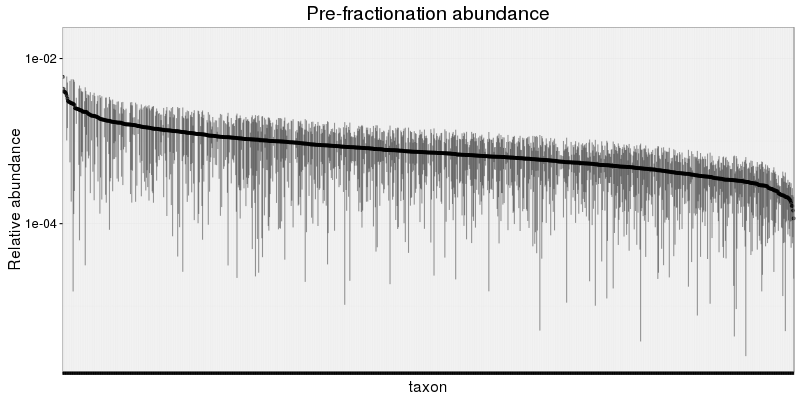

In [25]:
%%R -w 800 -h 400
# Plotting the pre-fractionation abundances of each taxon

df.SIM.comm.s = df.SIM.comm %>%
    group_by(taxon_name) %>%
    summarize(median_rank = median(rank),
              mean_abund = mean(bulk_abund),
              sd_abund = sd(bulk_abund))

df.SIM.comm.s$taxon_name = reorder(df.SIM.comm.s$taxon_name, -df.SIM.comm.s$mean_abund)

ggplot(df.SIM.comm.s, aes(taxon_name, mean_abund, 
                          ymin=mean_abund-sd_abund,
                          ymax=mean_abund+sd_abund)) +
    geom_linerange(alpha=0.4) +
    geom_point(alpha=0.6, size=1.2) +
    scale_y_log10() +
    labs(x='taxon', y='Relative abundance', title='Pre-fractionation abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

In [26]:
%%R

## joining SIP & comm (pre-fractionation)
df.SIM.j = inner_join(df.SIM, df.SIM.comm, c('library' = 'library',
                                             'taxon' = 'taxon_name',
                                             'SIM_rep' = 'SIM_rep')) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
    
df.SIM.j %>% head(n=3)

  library    fraction                          taxon BD_min BD_mid BD_max count
1       1 1.674-1.678 Acaryochloris_marina_MBIC11017  1.674  1.676  1.678    27
2       1 1.678-1.681 Acaryochloris_marina_MBIC11017  1.678  1.679  1.681     6
3       1 1.681-1.684 Acaryochloris_marina_MBIC11017  1.681  1.683  1.684     0
     rel_abund SIM_rep  bulk_abund rank
1 0.0012021371       3 0.005029363   15
2 0.0003171583       3 0.005029363   15
3 0.0000000000       3 0.005029363   15


In [27]:
%%R
# calculating BD range
df.SIM.j.f = df.SIM.j %>%
    filter(count > 0) %>%
    group_by(SIM_rep) %>%
    mutate(max_BD_range = max(BD_mid) - min(BD_mid)) %>%
    ungroup() %>%
    group_by(SIM_rep, taxon) %>%
    summarize(mean_bulk_abund = mean(bulk_abund),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / first(max_BD_range) * 100) %>%
    ungroup() 
    
df.SIM.j.f %>% head(n=3) %>% as.data.frame

  SIM_rep                                taxon mean_bulk_abund min_BD max_BD
1       1       Acaryochloris_marina_MBIC11017    0.0006275150  1.676  1.772
2       1       Acetobacterium_woodii_DSM_1030    0.0003909846  1.687  1.772
3       1 Acetobacter_pasteurianus_IFO_3283-03    0.0014681691  1.676  1.772
  BD_range BD_range_perc
1    0.096     100.00000
2    0.085      88.54167
3    0.096     100.00000


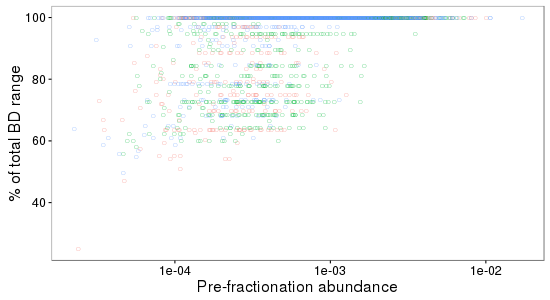

In [28]:
%%R -h 300 -w 550
## plotting
ggplot(df.SIM.j.f, aes(mean_bulk_abund, BD_range_perc, color=SIM_rep)) +
    geom_point(alpha=0.5, shape='O') +
    scale_x_log10() +
    scale_y_continuous() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )

# Assessing diversity

### Asigning zeros

In [29]:
%%R
# giving value to missing abundances
min.pos.val = df.SIM.j %>%
    filter(rel_abund > 0) %>%
    group_by() %>%
    mutate(min_abund = min(rel_abund)) %>%
    ungroup() %>%
    filter(rel_abund == min_abund)

min.pos.val = min.pos.val[1,'rel_abund'] %>% as.numeric
imp.val = min.pos.val / 10


# convert numbers
df.SIM.j[df.SIM.j$rel_abund == 0, 'abundance'] = imp.val

# another closure operation
df.SIM.j = df.SIM.j %>%
    group_by(SIM_rep, fraction) %>%
    mutate(rel_abund = rel_abund / sum(rel_abund))


# status
cat('Below detection level abundances converted to: ', imp.val, '\n')

Below detection level abundances converted to:  3.349972e-06 


## Plotting Shannon diversity for each

In [30]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    df = df %>% as.data.frame
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

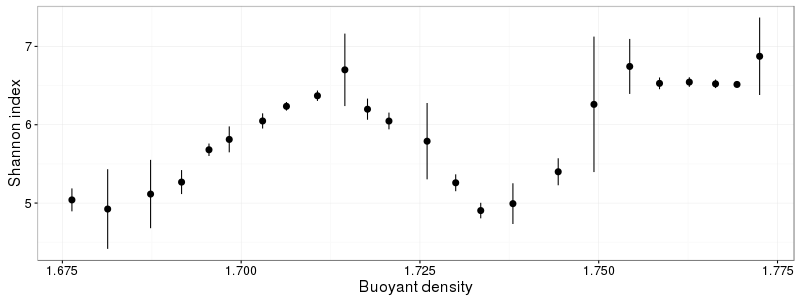

In [31]:
%%R -w 800 -h 300
# calculating shannon
df.SIM.shan = shannon_index_long(df.SIM.j, 'count', 'library', 'fraction') %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD) 

df.SIM.shan.s = df.SIM.shan %>%
    group_by(BD_bin = ntile(BD_mid, 24)) %>%
    summarize(mean_BD = mean(BD_mid),
              mean_shannon = mean(shannon),
              sd_shannon = sd(shannon))

# plotting
p = ggplot(df.SIM.shan.s, aes(mean_BD, mean_shannon, 
                             ymin=mean_shannon-sd_shannon,
                             ymax=mean_shannon+sd_shannon)) +
    geom_pointrange() +
    labs(x='Buoyant density', y='Shannon index') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Plotting variance


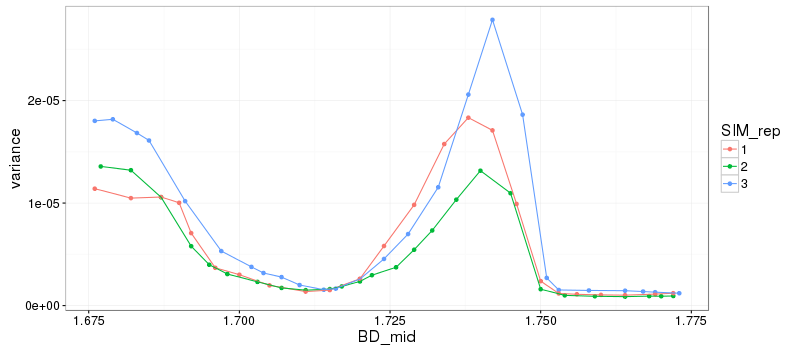

In [32]:
%%R -w 800 -h 350
df.SIM.j.var = df.SIM.j %>%
    group_by(SIM_rep, fraction) %>%
    mutate(variance = var(rel_abund)) %>%
    ungroup() %>%
    distinct(SIM_rep, fraction) %>%
    select(SIM_rep, fraction, variance, BD_mid)

ggplot(df.SIM.j.var, aes(BD_mid, variance, color=SIM_rep)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* spikes at low & high G+C
  * absence of taxa or presence of taxa at those locations?

# Plotting absolute abundance distributions 

In [33]:
OTU_files = !find $buildDir -name "OTU_abs1e9.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/3/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/2/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/1/OTU_abs1e9.txt']

In [34]:
%%R -i OTU_files
# loading files

df.abs = list()
for (x in OTU_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3/', '', x)
    SIM_rep = gsub('/OTU_abs1e9.txt', '', SIM_rep)
    df.abs[[SIM_rep]] = read.delim(x, sep='\t') 
    }
df.abs = do.call('rbind', df.abs)
df.abs$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.abs))
rownames(df.abs) = 1:nrow(df.abs)
df.abs %>% head(n=3)

  library                          taxon    fraction BD_min BD_mid BD_max count
1       1 Acaryochloris_marina_MBIC11017  -inf-1.660   -Inf  1.659  1.659   341
2       1 Acaryochloris_marina_MBIC11017 1.660-1.663  1.660  1.661  1.663   130
3       1 Acaryochloris_marina_MBIC11017 1.663-1.665  1.663  1.664  1.665    65
    rel_abund SIM_rep
1 0.004596740       3
2 0.006662225       3
3 0.004791037       3


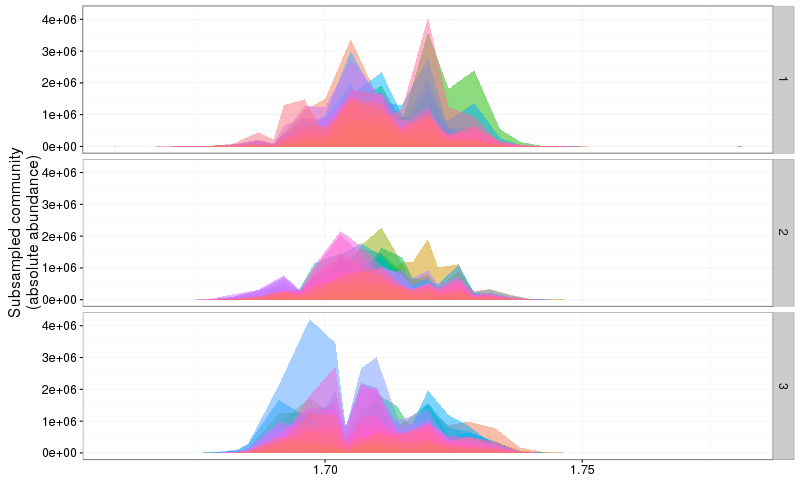

In [35]:
%%R -w 800 

ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

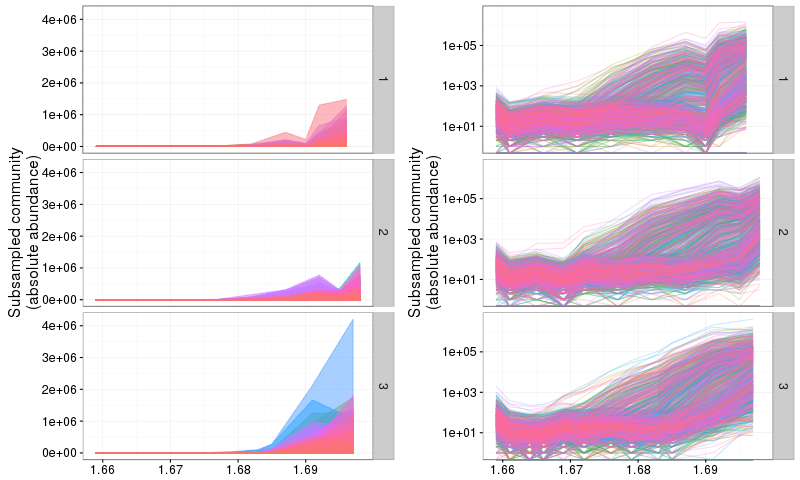

In [36]:
%%R -w 800 

p1 = ggplot(df.abs %>% filter(BD_mid < 1.7), aes(BD_mid, count, fill=taxon, color=taxon)) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

p2 = p1 + geom_line(alpha=0.25) + scale_y_log10()
p1 = p1 + geom_area(stat='identity', position='dodge', alpha=0.5) 

grid.arrange(p1, p2, ncol=2)

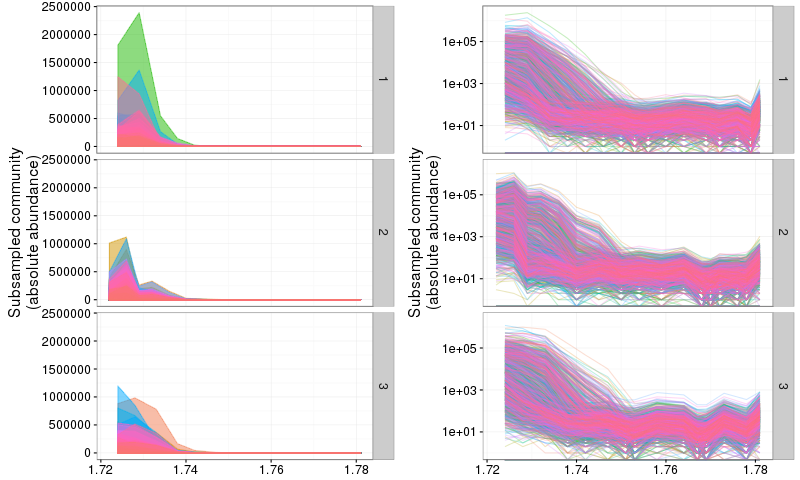

In [37]:
%%R -w 800 

p1 = ggplot(df.abs %>% filter(BD_mid > 1.72), aes(BD_mid, count, fill=taxon, color=taxon)) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )


p2 = p1 + geom_line(alpha=0.25) + scale_y_log10()
p1 = p1 + geom_area(stat='identity', position='dodge', alpha=0.5) 

grid.arrange(p1, p2, ncol=2)

# Conclusions

* DBL is a bit too permissive
  * low abundant taxa are spread out a bit more than emperical
* Variance spiking:
  * abundance distributions are too tight
    * emperical data variance suggests some extra unevenness in heavy fractions
      * some taxon DNA seems to be 'smeared' out into the heavy fractions
  * possible fixes:
    * more abundant, high G+C genomes
    * more diffusion
    * more 'smearing' into the heavy fractions
  * TODO:
    * determine what's changing in emperical data between Days 1,3,6 & 14,30,48